## Домашнє завдання: Побудова лінійної регресії за одною ознакою

Необхідні імпорти:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import math

from sklearn.linear_model import LinearRegression

В цьому домашньому завданні кожне завдання оцінюється по 10 балів.

### **Завдання 1.**

Після перегляду лекцій про поняття функії, вступ до лінійної алгебри і мат. формулювання лін. регресії знайдіть найкращу лінію для прогнозу `charges` за `age` **для некурців** (датафрейм `non_smoker_df`) з допомогою

1. Методу МНК (з використанням тільки `numpy`, без `scikit learn`)

2. Full-Batch градієнтного спуску з `numpy` . Протестуйте 3 різних learning rate і зробіть висновок, який є найкращим виходячи з практик для цього, наведених в лекції. Зверніть увагу, що на вхід треба набір даних дворозміний, для цього можливо треба буде трансформувати Ваші дані X в формат, як був в лекції "Математичне формулювання лінійної регресії". Також, градієнтний спуск в нашому випадку може розходитись з навчальним рейтом 0.1, бо цей рейт в цій задачі завеликий. Спробуйте нижчі рейти.
3. З `scikit-learn.LinearRegression`. Тут зверніть увагу, що вхід `X` має бути двовимірним масивом, тому нам потрібно передати dataframe, а не окрему колонку. Якщо у Вас X - колонка (а у Вас так мало б бути), то можна скористатись `X.to_frame()` щоб конвертувати колонку в датафрейм.

Для кожного методу
- знайдіть і виведіть коефіцієнти моделі
- обчисліть прогнози моделі і збережіть в окрему змінну
- порахуйте точність прогнозу RMSE  

Для градієнтного спуску виведіть графік помилки в залежності від ітерації.

А також побудуйте на одному графіку дані `age` проти `charges` в вигляді діаграми розсіювання і всі три лінії регресії, знайдені кожним з методів (для град. спуску оберіть варіант з тим learning rate, який виявився найкращим).

Зробіть висновки, чи відрізняються результати моделей?
Чи є знайдены параметри моделы близькими до ваших найкращих припущень?

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
file_name = '/content/drive/MyDrive/ML/data/medical-charges.csv'

In [4]:
medical_df = pd.read_csv(file_name) # замініть на ваш шлях до файлу
non_smoker_df = medical_df[medical_df.smoker == 'no']

In [5]:
ages = non_smoker_df.age
target = non_smoker_df.charges

Діаграма розкиду для не курців

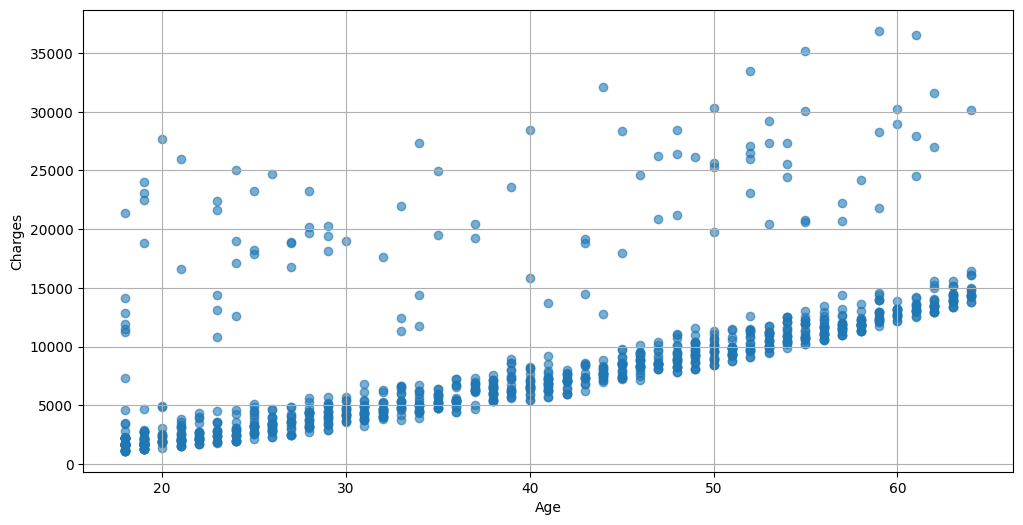

In [6]:
plt.figure(figsize=(12, 6))
plt.scatter(ages, target, alpha=0.6);
plt.xlabel('Age');
plt.ylabel('Charges')
plt.grid(True)

Маємо модель $charges = \theta_1 age + \theta_0$

#### Визначення функцій:

In [7]:
def rmse(targets, predictions):
    return np.sqrt(np.mean(np.square(targets - predictions)))

In [8]:
def visualize_prediction_line(scatter_data_x, scatter_data_y, x_label, y_label, pred_line, title):
  plt.figure(figsize=(12, 6))
  plt.plot(scatter_data_x, pred_line, 'r', alpha=0.9);
  plt.scatter(scatter_data_x, scatter_data_y,color='blue')
  plt.xlabel(x_label);
  plt.ylabel(y_label)
  plt.legend(['Estimate', 'Actual']);
  plt.title(title)
  plt.grid(True)

#### 1.1 Знаходження найкращої лінії через МНК

Для знаходження найкращих коєфіцієнтів для моделі $\theta$ методом найменших квадратів розв'язуємо рівняння:

$\theta = (X^TX)^{-1}X^Ty$


In [9]:
def least_squares_method(X, y):
  theta = np.dot(np.linalg.inv(np.dot(X.T, X)), X.T).dot(y)
  return theta[0], theta[1]

In [10]:
X = np.column_stack((np.ones(len(ages)), ages))

theta_0_lsm, theta_1_lsm = least_squares_method(X=X, y=target)

print(f"Коефіцієнти моделі: theta_0 = {theta_0_lsm}, theta_1 = {theta_1_lsm}")

Коефіцієнти моделі: theta_0 = -2091.4205565650805, theta_1 = 267.2489128311998


Обчислення прогнозу моделі:

In [11]:
estimated_charges_lsm = theta_1_lsm * ages + theta_0_lsm

In [12]:
loss_lsm = rmse(targets=target, predictions=estimated_charges_lsm)
print(f"точність прогнозу RMSE: {loss_lsm}")

точність прогнозу RMSE: 4662.505766636395


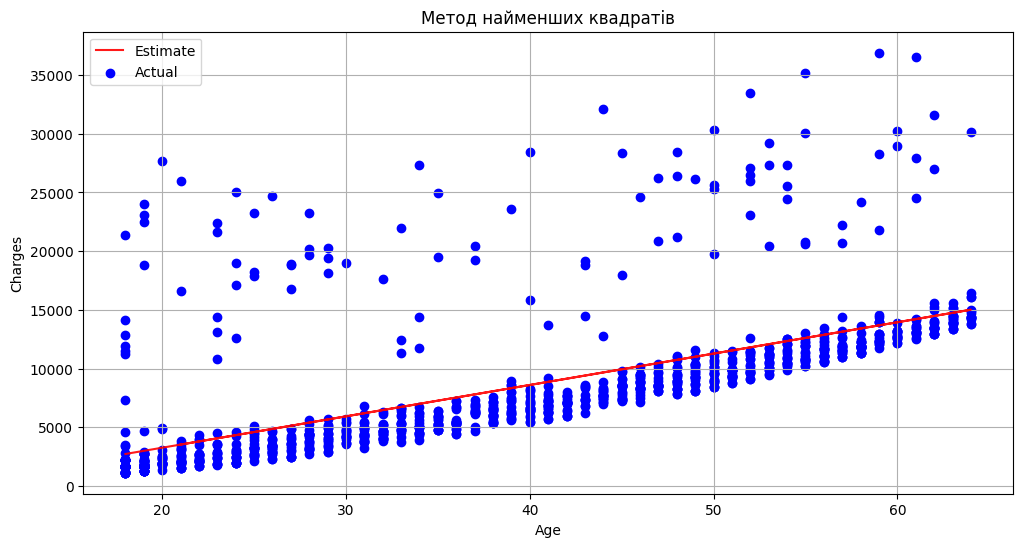

In [13]:
visualize_prediction_line(ages, target, 'Age', 'Charges', estimated_charges_lsm, title="Метод найменших квадратів")

**Спостереження**:

В результаті було знайдено наступні коефіцієнти моделі:
$\theta_0 = -2091.42056$, $\theta_1 = 267.2489$.

При цьому точність прогнозу **RMSE = 4662.5058**.

#### 1.2 Знаходження найкращої лінії за допомогою Full-Batch градієнтного спуску з numpy

In [14]:
class Prediction:
  def __init__(self, theta_0, theta_1, errors, loss, estimate, learning_rate):
    self.theta_0 = theta_0
    self.theta_1 = theta_1
    self.errors = errors
    self.loss = loss
    self.estimate = estimate
    self.learning_rate = learning_rate

In [15]:
def full_batch_gradient_descent(X, y, lr=0.1, epochs=100):
    m, b = 0.0, 0.0  # Початкові параметри
    n = len(y)
    errors = []
    for _ in range(epochs):
        y_pred = m * X[:, 0] + b
        error = y_pred - y
        errors.append(sum(error**2))
        m_gradient = (2/n) * np.dot(error, X[:, 0])
        b_gradient = (2/n) * np.sum(error)
        m = m - lr * m_gradient
        b = b - lr * b_gradient
    return m, b, errors

In [16]:
def estimate(learning_rate, epochs=5000):
  theta_1, theta_0, errors = full_batch_gradient_descent(X=ages.values.reshape(-1, 1), y=target.values, lr=learning_rate, epochs=epochs)
  estimate = theta_1 * ages + theta_0
  loss = rmse(targets=target, predictions=estimate)

  return Prediction(theta_0=theta_0, theta_1=theta_1, errors=errors, loss=loss, estimate=estimate, learning_rate=learning_rate)

In [17]:
learning_rates = [0.0001, 0.00001, 0.000001]
pred_res = [estimate(l) for l in learning_rates]

In [18]:
print(f"{'Lerning rate':<20} {'Theta 0':>10} {'Theta 1':>10} {'Loss':>10}")
for p in pred_res:
  print(f"{p.learning_rate:<20} {p.theta_0:>10.4f} {p.theta_1:>10.4f} {p.loss:>10.4f}")

Lerning rate            Theta 0    Theta 1       Loss
0.0001                -219.4486   225.1004  4704.8806
1e-05                  -18.6460   220.5792  4714.4063
1e-06                    2.5824   220.1012  4715.4689


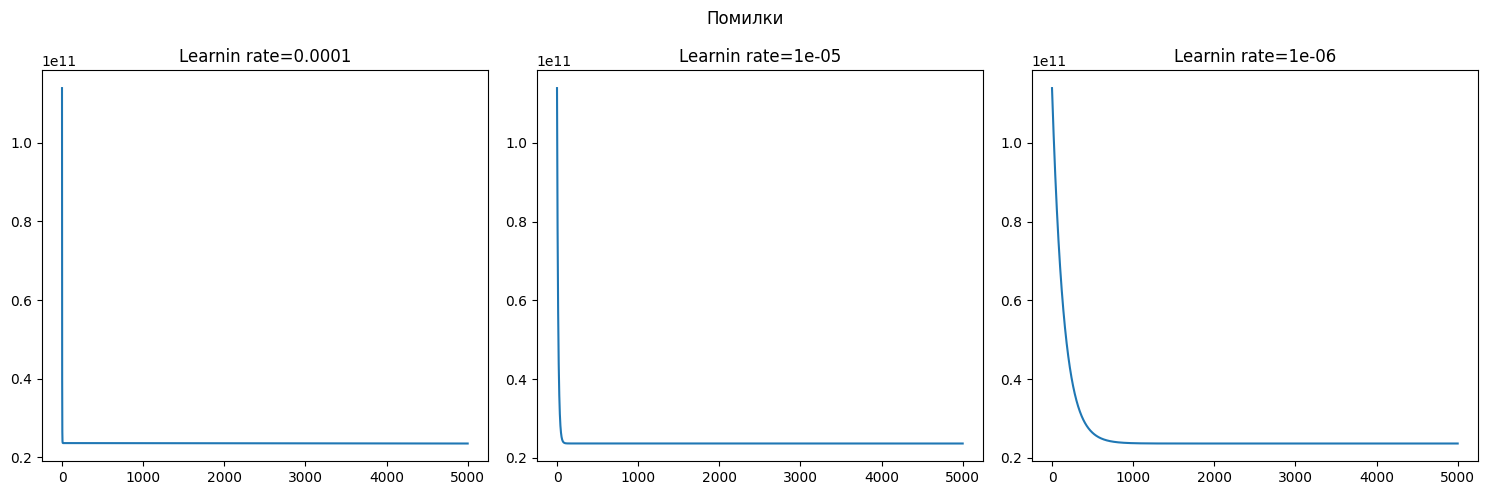

In [19]:
fig, axs = plt.subplots(1, len(pred_res), figsize=(15, 5))
fig.suptitle('Помилки', fontsize='large')
for i, p in enumerate(pred_res):
    axs[i].plot(p.errors)
    axs[i].set_title(f"Learnin rate={p.learning_rate}")
plt.tight_layout()
plt.show()

Накращий ЛР

In [20]:
cleaned_predictions = [p for p in pred_res if not math.isnan(p.loss)]
best_fbgd_prediction = min(cleaned_predictions, key=lambda prediction: prediction.loss)

estimated_charges_fbgd = best_fbgd_prediction.estimate
theta_0_fbgd = best_fbgd_prediction.theta_0
theta_1_fbgd = best_fbgd_prediction.theta_1
loss_fbgd = best_fbgd_prediction.loss

print(f"Коефіцієнти накращої моделі fbgd: theta_0 = {theta_0_fbgd}, theta_1 = {theta_1_fbgd}, точність прогнозу RMSE: {loss_fbgd}, learning_rate: {best_fbgd_prediction.learning_rate}")

Коефіцієнти накращої моделі fbgd: theta_0 = -219.44855828141417, theta_1 = 225.10036456939744, точність прогнозу RMSE: 4704.8806136741805, learning_rate: 0.0001


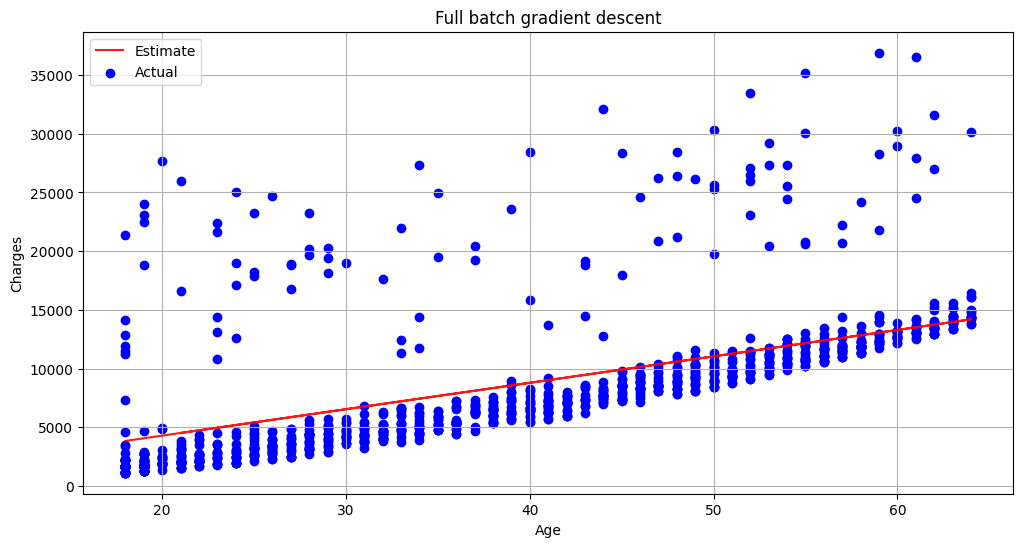

In [21]:
visualize_prediction_line(ages, target, 'Age', 'Charges', estimated_charges_fbgd, title="Full batch gradient descent")

**Спостереження**:

Було спробувано використання 3 різних **learning_rate (0.0001, 0.00001, 0.000001)**, з якими найкраще значення параметрів моделі було знайдено при **learning_rate = 0.0001**. При цьому значення $θ=−219.4485$,  $θ1=-225.1003$.

При цьому точність прогнозу **RMSE = 4704.8806**

#### 1.3 Знаходження найкращої лінії за допомогою Sklearn


In [22]:
model = LinearRegression()
model.fit(X=ages.values.reshape(-1, 1), y=target.values)

estimated_charges_sklearn = model.predict(ages.values.reshape(-1, 1))

theta_0_sklearn = model.intercept_
theta_1_sklearn = model.coef_[0]

print(f"Коефіцієнти моделі: theta_0 = {theta_0_sklearn}, theta_1 = {theta_1_sklearn}")

Коефіцієнти моделі: theta_0 = -2091.4205565650864, theta_1 = 267.2489128311997


In [23]:
loss_sklearn = rmse(targets=target, predictions=estimated_charges_sklearn)
print(f"Точність прогнозу RMSE: {loss_sklearn}")

Точність прогнозу RMSE: 4662.505766636395


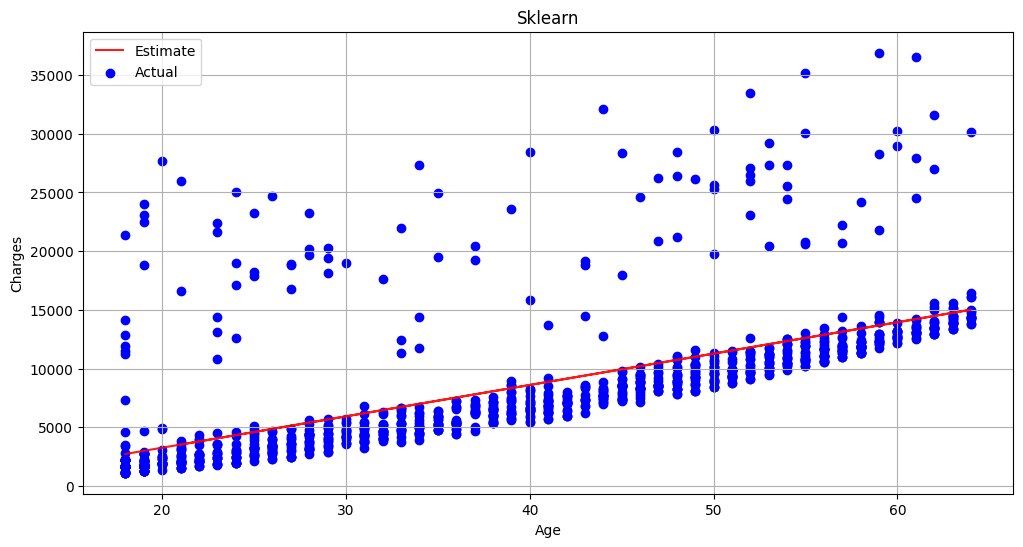

In [24]:
visualize_prediction_line(ages, target, 'Age', 'Charges', estimated_charges_sklearn, title="Sklearn")

**Спостереження**:

При знаходженні найкращої лінії за допомогою Sklearn було використано наступні коефіцієнти моделі $θ=-2091.4206$ ,  $θ1=267.2489$.

При цьому точність прогнозу **RMSE = 4662.5058**

#### Підсумок

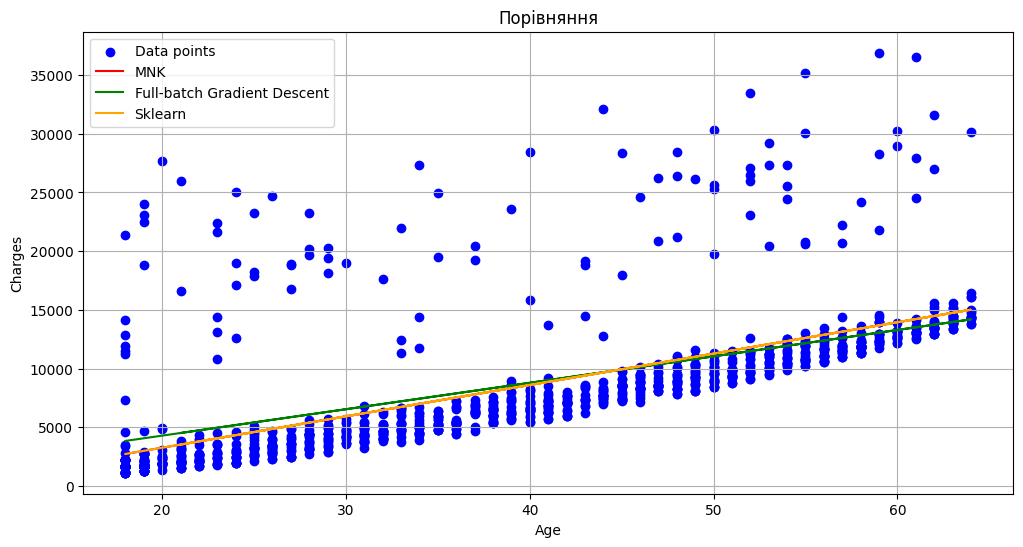

In [25]:
plt.figure(figsize=(12, 6))
plt.scatter(ages, target, color='blue', label='Data points')
plt.plot(ages, estimated_charges_lsm, color='red', label='MNK')
plt.plot(ages, estimated_charges_fbgd, color='green', label='Full-batch Gradient Descent')
plt.plot(ages, estimated_charges_sklearn, color='orange', label='Sklearn')
plt.title('Порівняння')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
print(f"{'Model':<20} {'Theta 0':>10} {'Theta 1':>10} {'Loss':>10}")
print(f"{'LSM':<20} {theta_0_lsm:>10.4f} {theta_1_lsm:>10.4f} {loss_lsm:>10.4f}")
print(f"{'FBGD':<20} {theta_0_fbgd:>10.4f} {theta_1_fbgd:>10.4f} {loss_fbgd:>10.4f}")
print(f"{'Sklearn':<20} {theta_0_sklearn:>10.4f} {theta_1_sklearn:>10.4f} {loss_sklearn:>10.4f}")


Model                   Theta 0    Theta 1       Loss
LSM                  -2091.4206   267.2489  4662.5058
FBGD                  -219.4486   225.1004  4704.8806
Sklearn              -2091.4206   267.2489  4662.5058


**Загальні спостереження**:

З побудованих знайдених ліній моделями бачимо, що в цілому кожна з ліній достатньо добре лягає на основне скупчення даних в розкиді, хоча і трішки припіднятою, що пов'язано з наявністю людей з порівняно великими витратами.

Також можемо бачити, що лінія МНК співпадє з лінією з Sklearn. Водночас лінія від Full batch gradient descent проходить дещо по іншій траєкторії.

Якщо подивимось на зведений вивід параметрів та точності передбачення моделі- можемо побачити, що з МНК та моделлю зі Sklearn значення коефіцієнтів співпадають, як і розраховане значення RMSE.

Коефіцієнти отримані з Full batch gradient descent дещо відрізняються, особливо $θ_0$. Значення RMSE вище, але не дуже суттєво, але при цьому був обраний learning_rate = 0.0001, при якому досягались найменші значення RMSE=4704.8806.

Щодо припущень, найкраще значення коефіцієнтів, що було підібрано вручну $θ_0=-2600$ $θ_1=280$. За таких значень коефіцієнтів моделі значення RMSE=4665.9639. Значення достатньо близькі до тих, що отримано з використанням моделей.

Можна спробувати відрізати дані, що виглядають як викиди, та розташовані над основним скупченням даних, та проаналізувати без цих викидів, так отримаємо більшу точність для прогнозування даних, що вписуються у основне скупчення.

 ### **Завдання 2.** Навчіть модель лінійної регресії з допомогою sklearn оцінювати розмір медичних збори для **курців** за їх віком.
Виведіть
- точність моделі
-  коефіцієнти
-  візуалізуйте модель у вигляді лінії на графіку розсіювання `age` проти `charges`

і зробіть висновки, чи це хороша модель, чи ви б її використовували в компанії?

In [27]:
smoker_df = medical_df[medical_df.smoker == 'yes']

In [28]:
ages_s = smoker_df.age
target_s = smoker_df.charges

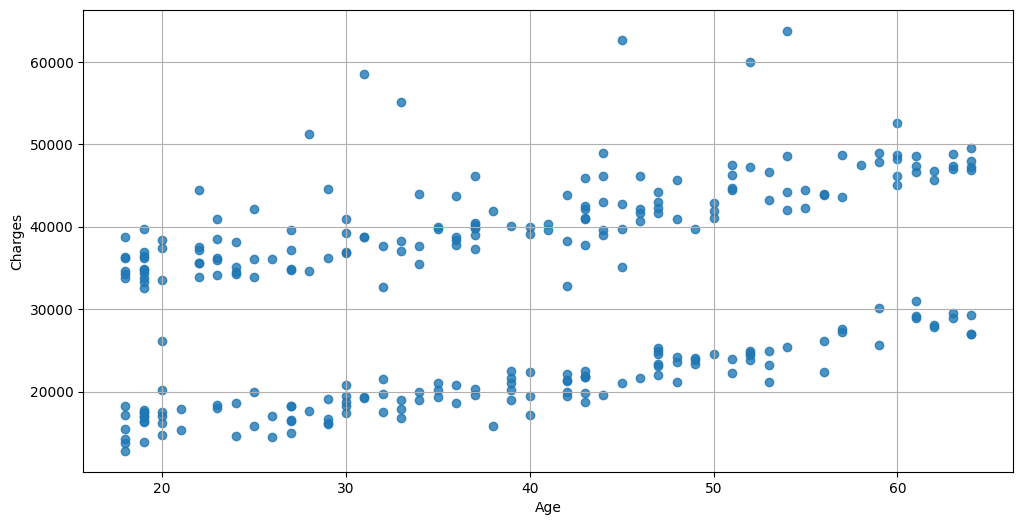

In [29]:
plt.figure(figsize=(12, 6))
plt.scatter(ages_s, target_s,alpha=0.8);
plt.xlabel('Age');
plt.ylabel('Charges')
plt.grid(True)

**Спостереження**:

Для курців в розкиді маємо дві окремі "хмари" даних, але, вприниципі загальну тенденцію. Хоча самі точки в кожної з скупчень наче тіршки осцилюють.

In [30]:
model = LinearRegression()
model.fit(X=ages_s.values.reshape(-1, 1), y=target_s.values)

estimated_charges_sklearn_smoker = model.predict(ages_s.values.reshape(-1, 1))

theta_0_s = model.intercept_
theta_1_s = model.coef_[0]

print(f"Коефіцієнти моделі: theta_0 = {theta_0_s}, theta_1 = {theta_1_s}")

Коефіцієнти моделі: theta_0 = 20294.128126915966, theta_1 = 305.2376021098288


In [31]:
loss_lr_s = rmse(targets=target_s, predictions=estimated_charges_sklearn_smoker)
print(f"Точність прогнозу RMSE: {loss_lr_s}")

Точність прогнозу RMSE: 10711.00334810241


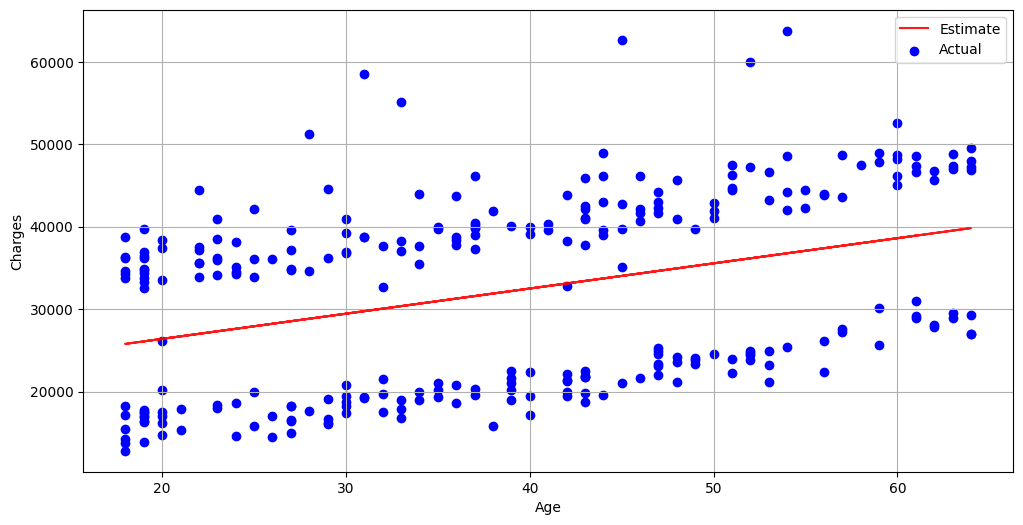

In [32]:
visualize_prediction_line(ages_s, target_s, 'Age', 'Charges', estimated_charges_sklearn_smoker, "")

**Спостереження**:

Прогнозована лінія лежить посередині між двома основними скупченнями точок. Тобто кожна з "хмар" перетягує на себе лінію, тому і отримали, результат десь по середині. Можемо сказати, що модель приблизно однаково помиляється і для кожної з груп даних.

##### Перевірка залишків

In [33]:
residuals = target_s.values - estimated_charges_sklearn_smoker

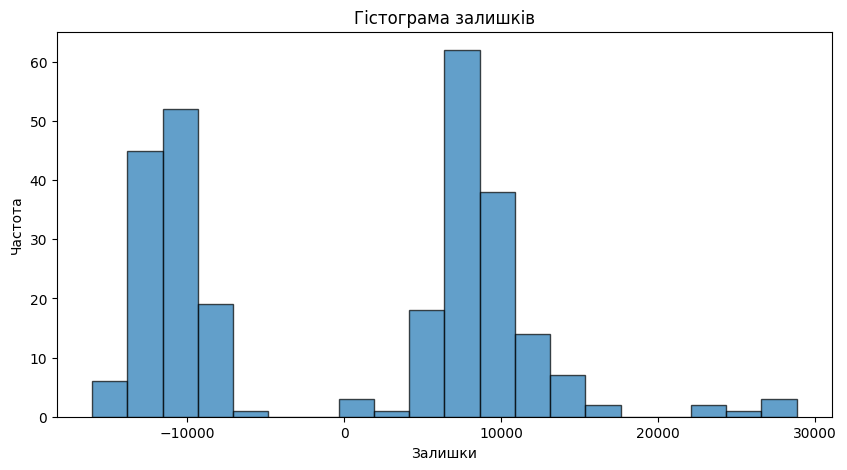

In [34]:
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=20, edgecolor='k', alpha=0.7)
plt.title("Гістограма залишків")
plt.xlabel("Залишки")
plt.ylabel("Частота")
plt.show()

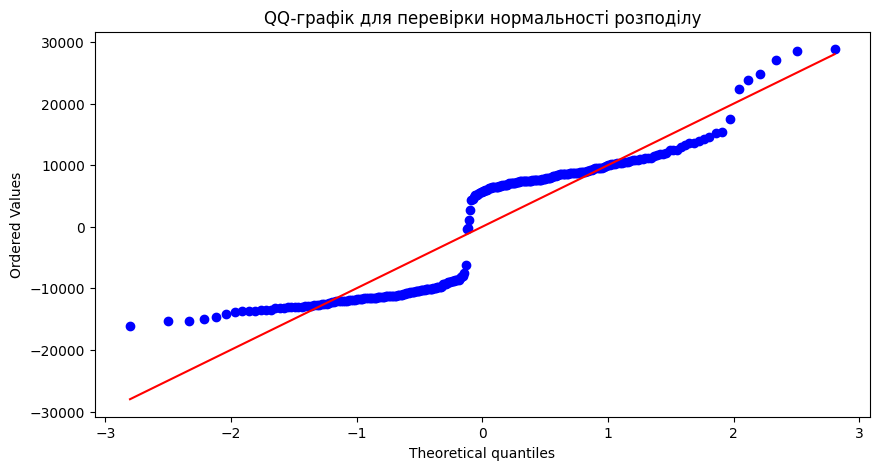

In [35]:
plt.figure(figsize=(10, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ-графік для перевірки нормальності розподілу")
plt.show()

**Аналіз залишків**:

- З гістограми залишків бачимо, що залишки мають дві основні групи, що може говорити про те, що в деяких випадках значення переоцінюється, а деяких не дооцінюється.
- Залишки не відповідають нормальному розподілу, що також доводить QQ графік.
- Можемо сказати про не велику точність моделі.

## Висновок

**Якість моделі**: на жаль, модель є не точною. Для використання у роботі дана модель немає достатньої точності.

**Чи може бути використана у роботі**: Модель може бути використана, для визначення загальної приблизної тенденції впливу віку на витрати, але використовувати її для прогнозу не дуже було б коректно.

Дивлячись на діаграму розкиду ми можемо виділити два основних скупчення даних, тому це наводить на думку дослідити їх окремо. Це збільшить точність моделі, але при моделюванні залежності тільки для конкретної групи. Якщо було б відомо, що переводить клієнта з однієї групи витрат у іншу, потенційно це могло бути корисно. Але для аналізу курців вцілому, ми не можемо точно передбачити залежність їх витрат від віку.

Тобто коли у клієнта з'являється фактор куріння, ми не можемо покладатися лише на вік, треба шукати, що ще впливає на витрати.

#### Додаткові експерименти

In [36]:
def categorize_charges(charges):
    if charges < 30000:
        return 'Low'
    elif 30000 <= charges < 50000:
        return 'Middle'
    else:
        return 'High'

In [37]:
smoker_df = smoker_df.copy()
smoker_df['charges_segment'] = smoker_df['charges'].apply(categorize_charges)

In [38]:
df_low = smoker_df[smoker_df.charges_segment == 'Low']
df_middle = smoker_df[smoker_df.charges_segment == 'Middle']
df_high = smoker_df[smoker_df.charges_segment == 'High']

In [39]:
def prediction_lr_model(df):
  X=df.age.values.reshape(-1, 1)
  y=df.charges.values

  model = LinearRegression()
  model.fit(X=X, y=y)

  predicted_charges = model.predict(X)

  theta_0 =  model.intercept_
  theta_1 = model.coef_[0]

  loss = rmse(targets=y, predictions=predicted_charges)

  return predicted_charges, theta_0, theta_1, loss

In [40]:
prediction_low, theta_0_low, theta_1_low, loss_low = prediction_lr_model(df_low)
prediction_middle, theta_0_middle, theta_1_middle, loss_middle = prediction_lr_model(df_middle)
prediction_high, theta_0_high, theta_1_high, loss_high = prediction_lr_model(df_high)

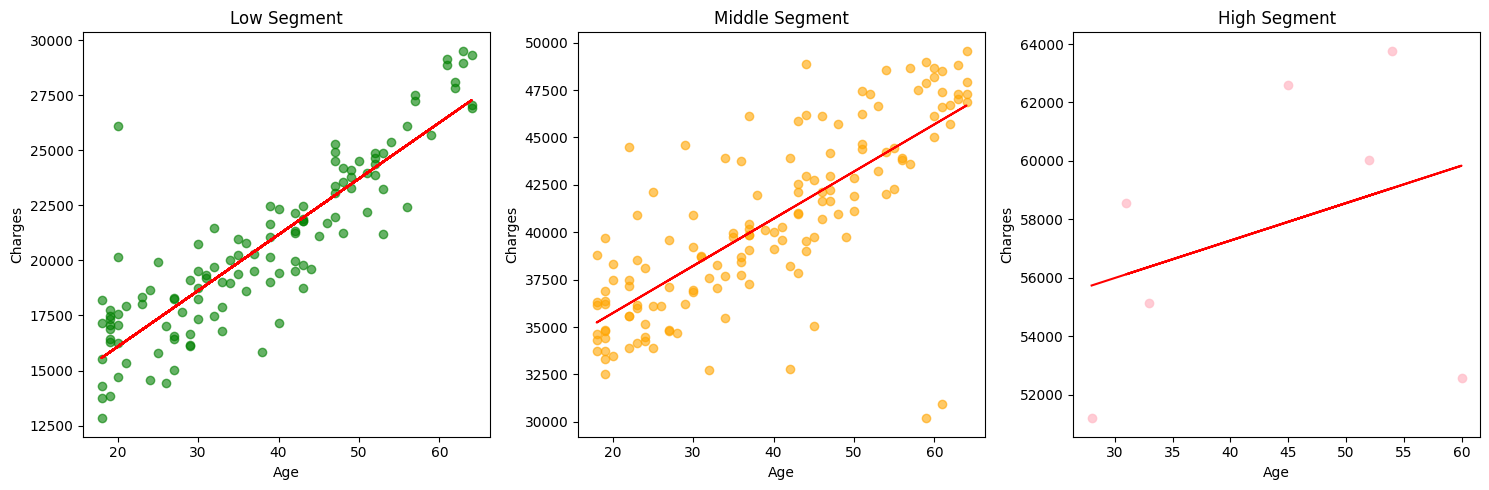

Segment                 Theta 0    Theta 1       Loss
Low                  11000.5164   254.2621  1850.5535
Middle               30759.3831   248.8933  3112.1407
High                 52153.3993   128.0619  4244.9860
General Model        20294.1281   305.2376 10711.0033


In [41]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(df_low.age, prediction_low, color='red', label='Estimate')
axs[0].scatter(df_low['age'], df_low['charges'], color='green', alpha=0.6)
axs[0].set_title('Low Segment')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Charges')

axs[1].plot(df_middle.age, prediction_middle, color='red', label='Estimate')
axs[1].scatter(df_middle['age'], df_middle['charges'], color='orange', alpha=0.6)
axs[1].set_title('Middle Segment')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Charges')

axs[2].plot(df_high.age, prediction_high, color='red', label='Estimate')
axs[2].scatter(df_high['age'], df_high['charges'], color='pink', alpha=0.8)
axs[2].set_title('High Segment')
axs[2].set_xlabel('Age')
axs[2].set_ylabel('Charges')

plt.tight_layout()
plt.show()

print(f"{'Segment':<20} {'Theta 0':>10} {'Theta 1':>10} {'Loss':>10}")
print(f"{'Low':<20} {theta_0_low:>10.4f} {theta_1_low:>10.4f} {loss_low:>10.4f}")
print(f"{'Middle':<20} {theta_0_middle:>10.4f} {theta_1_middle:>10.4f} {loss_middle:>10.4f}")
print(f"{'High':<20} {theta_0_high:>10.4f} {theta_1_high:>10.4f} {loss_high:>10.4f}")
print(f"{'General Model':<20} {theta_0_s:>10.4f} {theta_1_s:>10.4f} {loss_lr_s:>10.4f}")

### Висновок


Якщо розділити дані по основним скупченням, що бачимо - можна дійсно підібрати краще коефіцієнти для моделювання зв'язку між віком та витратами у рамках самої групи.

Тобто є якийсь інший чинник, що впливає на витрати курців, який фактично переводить їх у іншу категорію витрат клієнтів, і це не змінна Ages.

Ми дійсно можемо бачити, що для конкретної групи витрат можемо більш точно передбачувати які будуть витрати (у діапазоні групи, що розглядаємо) від віку. Тому доцільно пошукати в даних, що саме може переводити клієнта до такої групи. Адже тенденція для кожної з груп в цілому однакова (не враховуючи High) що з віком витрати зростають, але щось інше впливає на діапазон витрат.
